### Setup libraries
Let's start with some imports. 


In [23]:
from __future__ import print_function, unicode_literals, absolute_import, division

# autoreload modules before executing
%load_ext autoreload
%autoreload 2

import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import shutil
import pandas as pd
import pprint
import sys
# Setup pretty printing
pp = pprint.PrettyPrinter(indent=4)


font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)
%matplotlib inline



from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

# importing some utilities from microDL in the first half.
# Add microdl path to sys
module_path = os.path.abspath(os.path.join('..'))
print("System path: "+module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import micro_dl.utils.image_utils as im_utils
import micro_dl.utils.masks as mask_utils
import micro_dl.utils.normalize as norm_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System path: /home/mehtas/04_image_translation/microDL


## A. Prepare dataset for training

### Paths

In [36]:
INPUT_DIR = os.path.expanduser('~/04_image_translation/data/')

positions = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Copy the data in a format expected by CARE pipeline. 
# CARE data generator requires the source and target files to be saved in different formats with matching filenames.

# subset retardance images
if not os.path.exists(INPUT_DIR + 'care_retardance'):
    os.mkdir(INPUT_DIR + 'care_retardance')
for pos in positions:
    srcfiles= glob.glob(INPUT_DIR + 'img_Retardance_*p{:03d}'.format(pos)+ '*')
    dstfiles= [path.replace('img_Retardance_','care_retardance/img_') for path in srcfiles]
    for src, dst in zip(srcfiles,dstfiles):
        shutil.copy(src,dst)

# subset phase images
if not os.path.exists(INPUT_DIR + 'care_phase'):
    os.mkdir(INPUT_DIR + 'care_phase')
for pos in positions:
    srcfiles= glob.glob(INPUT_DIR + 'img_phase_*p{:03d}'.format(pos)+ '*')
    dstfiles= [path.replace('img_phase_','care_phase/img_') for path in srcfiles]
    for src, dst in zip(srcfiles,dstfiles):
        shutil.copy(src,dst)
        
# subset F-actin images
if not os.path.exists(INPUT_DIR + 'care_factin'):
    os.mkdir(INPUT_DIR + 'care_factin')
        
for pos in positions:
    srcfiles= glob.glob(INPUT_DIR + 'img_568_*p{:03d}'.format(pos)+ '*')
    dstfiles= [path.replace('img_568_','care_factin/img_') for path in srcfiles]
    for src, dst in zip(srcfiles,dstfiles):
        shutil.copy(src,dst)

# subset DNA images
if not os.path.exists(INPUT_DIR + 'care_dna'):
    os.mkdir(INPUT_DIR + 'care_dna')
        
for pos in positions:
    srcfiles= glob.glob(INPUT_DIR + 'img_405_*p{:03d}'.format(pos)+ '*')
    dstfiles= [path.replace('img_405_','care_dna/img_') for path in srcfiles]
    for src, dst in zip(srcfiles,dstfiles):
        shutil.copy(src,dst)

### Explore input and target images <a class="anchor" id="explore"></a>

The goal of this exercise is to translate 2D slices of phase or retardance image into 2D slices of fluorescene images of F-actin and DNA. Let's start by looking at some example images.

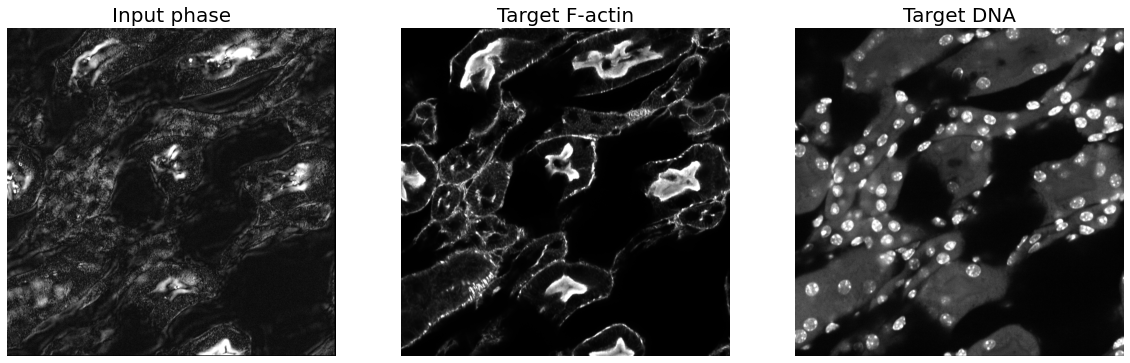

In [43]:
# import the libaries again if the plots don't display properly
img_name = 'img_t000_p003_z010.tif'
actin_path = os.path.join(INPUT_DIR, 'care_factin/', img_name) #F-actin was imaged with Alexa Fluor 568 using 468nm excitation wavelength.
dna_path=os.path.join(INPUT_DIR, 'care_dna/', img_name) # DNA was imaged with Hoechst using 405nm excitation wavelength.
input_path=os.path.join(INPUT_DIR,'care_retardance/', img_name) # the phase and polarization were imaged using 530nm wavelength.

actin = imread(actin_path)
# This will clip the top and bottom 1% of intensitites
actin = norm_utils.hist_clipping(actin, 1, 99)
dna = imread(dna_path)
dna = norm_utils.hist_clipping(dna, 1, 99)
im_input = imread(input_path) 
im_input = norm_utils.hist_clipping(im_input, 0.8, 99.5) 
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
ax = ax.flatten()
ax[0].imshow(im_input, cmap='gray')
ax[0].set_title('Input phase',fontsize=20)
ax[1].imshow(actin, cmap='gray')
ax[1].set_title('Target F-actin',fontsize=20)
ax[2].imshow(dna, cmap='gray')
ax[2].set_title('Target DNA',fontsize=20)
for a in ax: a.axis('off')

plt.show()
plt.close('all')

### Create a data generator and patches

In [79]:
from csbdeep.data import no_background_patches, norm_percentiles, sample_percentiles
patch_file = INPUT_DIR+'phase_dna_care.npz'

raw_data = RawData.from_folder (
    basepath    = INPUT_DIR,
    source_dirs = ['care_phase'],
    target_dir  = 'care_dna',
    axes        = 'YX',
)

X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (256,256),
    patch_filter        = no_background_patches(0.5),
    n_patches_per_image = 128,
    save_file           = patch_file,
)
# TODO: include augmentations (transforms = ???)

   60 raw images x    1 transformations   =    60 images
   60 images     x  128 patches per image =  7680 patches in total
Input data:
/home/mehtas/04_image_translation/data/: target='care_dna', sources=['care_phase'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
256 x 256


100%|██████████| 60/60 [00:30<00:00,  1.98it/s]


Saving data to /home/mehtas/04_image_translation/data/phase_dna_care.npz.


shape of X,Y = (7680, 1, 256, 256)
axes  of X,Y = SCYX


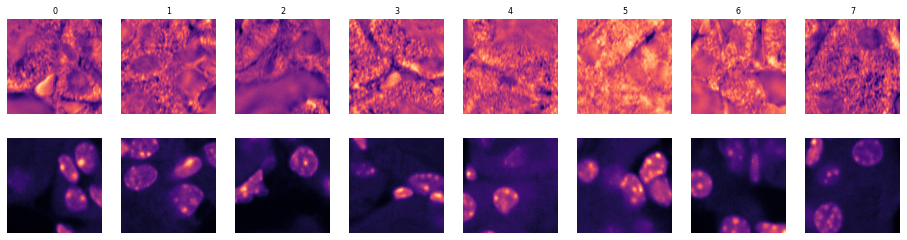

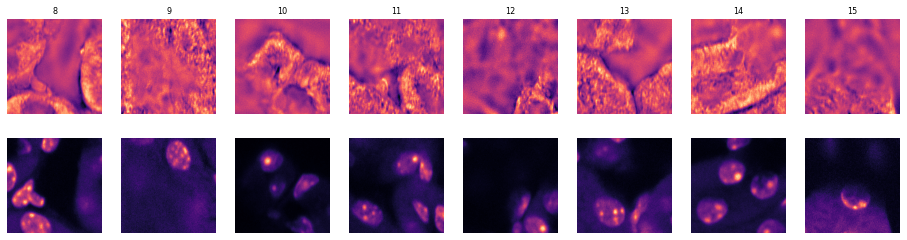

In [80]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)


for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;
## TODO: plot in grayscale.

### Checkpoint A

## B. 2D virtual staining (slice$\rightarrow$slice) using CARE <a class="anchor" id="pilot"></a>

### Load training data and configure

In [81]:
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
patch_file = os.path.expanduser('~/04_image_translation/data/phase_dna_care.npz')


In [82]:
(X,Y), (X_val,Y_val), axes = load_training_data(patch_file, validation_split=0.1, verbose=False)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

In [90]:
config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=3, train_batch_size=16, train_steps_per_epoch=10, unet_n_depth = 3, train_epochs = 30, unet_residual = True)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=30, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=10, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 30,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [91]:
model = CARE(config, 'phase2DNA_bath16_depth3', basedir='/home/mehtas/04_image_translation/care_model') 

In [92]:
model.keras_model.summary()
model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, None, None, 3 9248        down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, None, None, 3 0           down_level_0_no_1[0][0]          
__________________________________________________________________________________________________
down_level

CARE(phase2DNA_bath16_depth3): YXC → YXC
├─ Directory: /home/mehtas/04_image_translation/care_model/phase2DNA_bath16_depth3
└─ Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=30, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=10, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)

### Time to train. 

Try restarting the notebook kernel if the gpu memory is occupied and you run into errors about "can't creat training session".
Training 6 epochs should take no more than 5 minutes if you're on a GPU.

In [93]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/30
10/10 [==============================] - 7s 729ms/step - loss: 0.1960 - mse: 0.0659 - mae: 0.1960 - val_loss: 0.1429 - val_mse: 0.0426 - val_mae: 0.1429
Epoch 2/30
10/10 [==============================] - 6s 565ms/step - loss: 0.1400 - mse: 0.0426 - mae: 0.1400 - val_loss: 0.1282 - val_mse: 0.0376 - val_mae: 0.1282
Epoch 3/30
10/10 [==============================] - 6s 567ms/step - loss: 0.1255 - mse: 0.0381 - mae: 0.1255 - val_loss: 0.1199 - val_mse: 0.0328 - val_mae: 0.1199
Epoch 4/30
10/10 [==============================] - 6s 568ms/step - loss: 0.1241 - mse: 0.0381 - mae: 0.1241 - val_loss: 0.1166 - val_mse: 0.0360 - val_mae: 0.1166
Epoch 5/30
10/10 [==============================] - 6s 571ms/step - loss: 0.1165 - mse: 0.0342 - mae: 0.1165 - val_loss: 0.1139 - val_mse: 0.0354 - val_mae: 0.1139
Epoch 6/30
10/10 [==============================] - 6s 575ms/step - loss: 0.1177 - mse: 0.0364 - mae: 0.1177 - val_loss: 0.1108 - val_mse: 0.0316 - val_mae: 0.1108
Epoch 7/30
10/10

We've completed our first training. Let's take a look at what happened during training by opening a history log file.

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


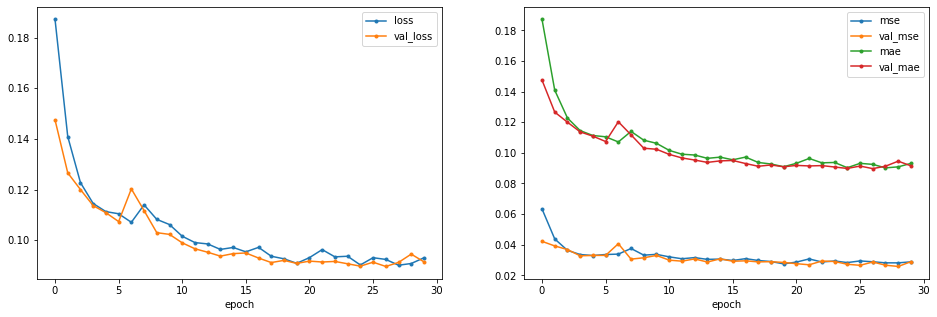

In [88]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

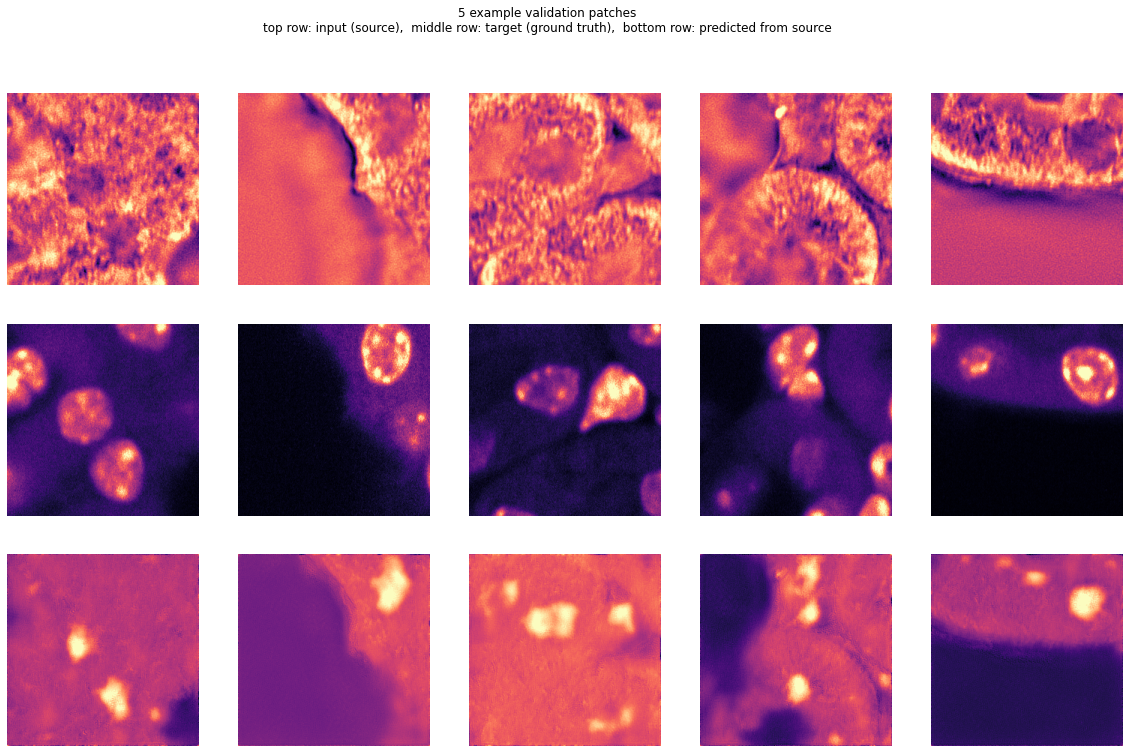

In [94]:
plt.figure(figsize=(20,12))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [95]:
x_val_min = np.min(X_val[:])
x_val_max = np.max(X_val[:])
print(f'size of validation input: {X_val[:5].shape}, range of validation input: [{x_val_min}, {x_val_max}]')

size of validation input: (5, 256, 256, 1), range of validation input: [-2.6406784057617188, 1.7224944829940796]


### Checkpoint B

## C. Prediction on test position not seen by model

input range: -1.0426136255264282


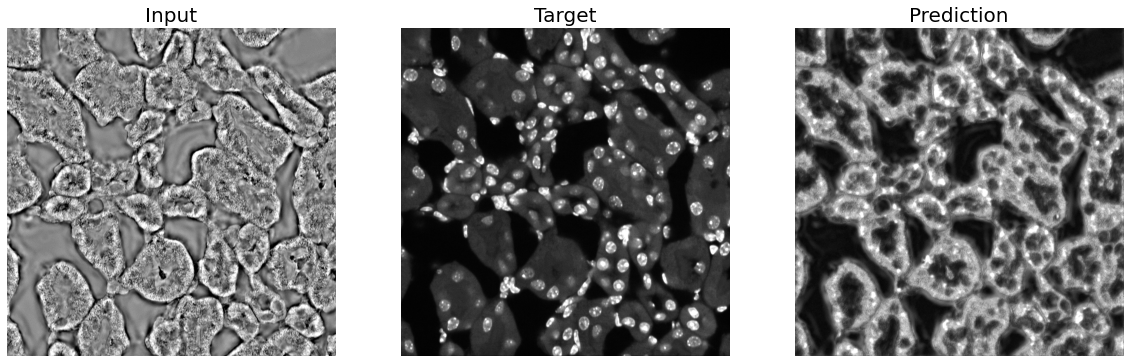

In [98]:
# Read test image and scale the uint16 image to match the dynamic range of validation set.

im_path = os.path.join(INPUT_DIR, 'img_phase_t000_p090_z015.tif')
test_input = imread(im_path).astype('float32')
test_input -= np.mean(test_input[:])
test_input /= np.max(test_input[:])
test_input *= x_val_max


prediction = model.keras_model.predict(test_input.reshape(1,2048,2048,1)) # Note that the input needs to be reshaped in (batch, Y, X, C) order.
prediction = prediction.reshape(2048,2048)
im_path = os.path.join(INPUT_DIR, 'img_405_t000_p090_z015.tif')
target = imread(im_path)

print(f'input range: {np.min(test_input[:])}')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
ax = ax.flatten()
for a in ax: a.axis('off')
    
ax[0].imshow(norm_utils.hist_clipping(test_input, 1, 99), 
             cmap='gray');
ax[0].set_title('Input', fontsize=20)

ax[1].imshow(norm_utils.hist_clipping(target, 1, 99), 
             cmap='gray'); 
ax[1].set_title('Target', fontsize=20)

ax[2].imshow(norm_utils.hist_clipping(prediction, 1, 99), 
             cmap='gray'); 
ax[2].set_title('Prediction', fontsize=20)

plt.show()
plt.close('all')

### Checkpoint C